This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# A Typical Workflow For Radar-Based Rainfall Estimation

Raw, unprocessed reflectivity products can already provide useful visual information about the spatial distribution of rainfall fields. However, in order to use weather radar observations for quantitative studies (e.g. in hydrological modelling or for assimilation into Numerical Weather Prediction models), the data has to be carefully processed in order to account for typical errors sources such as ground echoes (clutter), attenuation of the radar signal, or uncertainties in the Z/R relationship.

Moreover, it might be necessary to transfer the data from polar coordinates to Cartesian grids, or to combine observations from different radar locations in overlapping areas on a common grid (composition). And in the end, you would typically like to visualise the spatial rainfall distribution on a map. Many users also need to quantify the potential error (uncertainty) of their data-based rainfall estimation.

These are just some steps that might be necessary in order to make radar data useful in a specific quantitative application environment. All steps together are typically referred to as a *"radar data processing chain"*. $\omega radlib$ was designed to support you in establishing your own processing chain, suited to your specific requirements. In the following, we will provide an outline of a typical processing chain, step-by-step. You might not need all steps for your own workflow, or you might need steps which are not yet included here.

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

## Introduction

Consider this just as an example. We will not go into detail for each step in this section, but refer to more detailed tutorials (if available) or the corresponding entry in the library reference. Most of the steps have a corresponding $\omega radlib$ module. In order to access the functions of $\omega radlib$, you have to import $\omega radlib$ in your Python environment:

```python
import wradlib as wrl
```

If you have trouble with that import, please head back to the [Getting Started](https://docs.wradlib.org/en/latest/gettingstarted.html) section.

<div class="alert alert-info">

**Note** <br>

The data used in this tutorial can be found in the [wradlib-data repository](https://github.com/wradlib/wradlib-data). Follow [these instructions](https://github.com/wradlib/wradlib-data/blob/master/README.md) to install and use this data files.

</div>

<div class="alert alert-warning">

**Warning** <br>

Be aware that applying an algorithm for error correction does not guarantee that the error is totally removed. Error correction procedures are suceptible to errors, too. Not only might they fail to *remove* the error. They might also introduce *new* errors. The trade-off between costs (introduction of new errors) and benefits (error reduction) can turn out differently for different locations, different points in time, or different rainfall situations.

</div>

## Reading the data

The binary encoding of many radar products is a major obstacle for many potential radar users. Often, decoder software is not easily available. $\omega radlib$ supports a couple of formats such as the ODIM_H5 implementation, NetCDF, and some formats used by the German Weather Service. We seek to continuously enhance the range of supported formats.

The basic data type used in $\omega radlib$ is a multi-dimensional array, the numpy.ndarray. Such an array might e.g. represent a polar or Cartesian grid, or a series of rain gage observations. Metadata are normally managed as Python dictionaries. In order to read the content of a data file into a numpy array, you would normally use the [wradlib.io](https://docs.wradlib.org/en/latest/io.html) module. In the following example, a local PPI from the German Weather Service, a DX file, is read:

<Figure size 720x576 with 0 Axes>

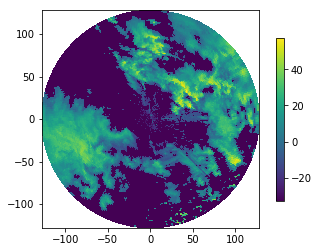

In [2]:
import pylab as pl
pl.figure(figsize=(10,8))
filename = wrl.util.get_wradlib_data_file('dx/raa00-dx_10908-0806021655-fbg---bin.gz')
data, metadata = wrl.io.read_dx(filename)
ax, pm = wrl.vis.plot_ppi(data) # simple diagnostic plot
cbar = pl.colorbar(pm, shrink=0.75)

The ``metadata`` object can be inspected via keywords. The ``data`` object contains the actual data, in this case a polar grid with 360 azimuth angles and 128 range bins.

<div class="alert alert-info">

**Seealso** <br>

Get more info in the section [Supported radar data formats](../fileio/wradlib_radar_formats.ipynb) and in the library reference section [Raw Data I/O](https://docs.wradlib.org/en/latest/io.html).

</div>

## Clutter removal

Clutter are non-meteorological echos. They are caused by the radar beam hitting objects on the earth's surface (e.g. mountain or hill tops, houses, wind turbines) or in the air (e.g. airplanes, birds). These objects can potentially cause high reflectivities due large scattering cross sections. Static clutter, if not efficiently removed by Doppler filters, can cause permanent echos which could introduce severe bias in quantitative applications. Thus, an efficient identification and removal of clutter is mandatory e.g. for hydrological studies. Clutter removal can be based on static maps or dynamic filters. Normally, static clutter becomes visible more clearly in rainfall accumulation maps over periods of weeks or months. We recommend such accumulations to create static clutter maps which can in turn be used to remove the static clutter from an image and fill the resulting gaps by interpolation. 

In the following example, the clutter filter published by [Gabella et al., 2002](https://docs.wradlib.org/en/latest/zreferences.html#gabella2002)) is applied to the single radar sweep of the above example:

Text(0.5, 1.0, 'Clutter Map')

<Figure size 720x576 with 0 Axes>

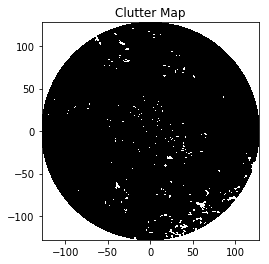

In [3]:
clutter = wrl.clutter.filter_gabella(data, tr1=12, n_p=6, tr2=1.1)
pl.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(clutter, cmap=pl.cm.gray)
pl.title('Clutter Map')

The resulting Boolean array ``clutter`` indicates the position of clutter. It can be used to interpolate the values at those positons from non-clutter values, as shown in the following line:

<Figure size 720x576 with 0 Axes>

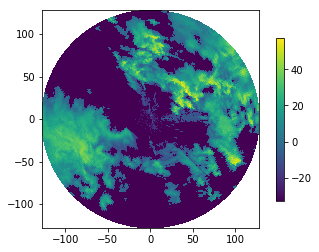

In [4]:
data_no_clutter = wrl.ipol.interpolate_polar(data, clutter)
pl.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(data_no_clutter) # simple diagnostic plot
cbar = pl.colorbar(pm, shrink=0.75)

It is generally recommended to remove the clutter before e.g. gridding the data. Otherwise the clutter signal might be "smeared" over multiple grid cells, resulting into a decrease in detectability.

<div class="alert alert-info">

**Seealso** <br>

Get more info in the library reference section [Clutter Identification](https://docs.wradlib.org/en/latest/clutter.html).

</div>

## Attenuation correction

Attenuation by wet radome and by heavy rainfall can cause serious underestimation of rainfall for [C-Band and X-Band](https://www.everythingweather.com/weather-radar/bands.shtml) devices. For such radar devices, situations with heavy rainfall require a correction of attenuation effects. <br>
The general approach with single-polarized radars is to use a recursive gate-by-gate approach. See [Kraemer et al., 2008](https://docs.wradlib.org/en/latest/zreferences.html#kraemer2008) for an introduction to this concept. Basically, the specific attenuation ``k`` of the first range gate is computed via a so-called ``k-Z`` relationship. Based on ``k``, the reflectivity of the second range gate is corrected and then used to compute the specific attenuation for the second range gate (and so on). <br>
The concept was first introduced by [Hitschfeld et al., 1954)](https://docs.wradlib.org/en/latest/zreferences.html#hitschfeld1954). Its main drawback is its suceptibility to instable behaviour. $\omega radlib$ provides different implementations which address this problem.

One example is the algorithm published by [Jacobi and Heistermann, 2016](https://docs.wradlib.org/en/latest/zreferences.html#jacobi2016):

In [5]:
pia = wrl.atten.correct_attenuation_constrained(data_no_clutter, a_max=1.67e-4, a_min=2.33e-5,
                                                n_a=100, b_max=0.7, b_min=0.65, n_b=6, 
                                                gate_length=1., constraints=[wrl.atten.constraint_dbz, 
                                                                             wrl.atten.constraint_pia],
                                                constraint_args=[[59.0],[20.0]])
data_attcorr = data_no_clutter + pia

The first line computes the path integrated attenuation ``pia`` for each radar bin. The second line uses ``pia`` to correct the reflectivity values. Let's inspect the effect of attenuation correction for an azimuth angle of 65 deg:

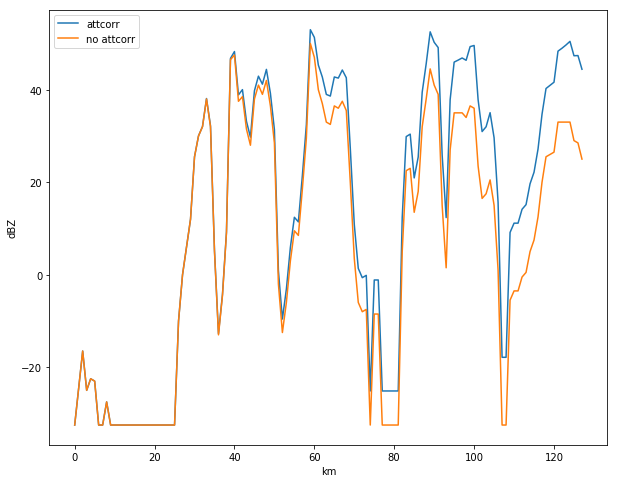

In [6]:
pl.figure(figsize=(10,8))
pl.plot(data_attcorr[65], label="attcorr")
pl.plot(data_no_clutter[65], label="no attcorr")
pl.xlabel("km")
pl.ylabel("dBZ")
pl.legend()

<div class="alert alert-info">

**Seealso** <br>

Get more info in the library reference section [Attenuation Correction](https://docs.wradlib.org/en/latest/atten.html). There you will learn to know the algorithms available for attenuation correction and how to manipulate their behaviour by using additonal keyword arguments.   

</div>

## Vertical Profile of Reflectivity

Precipitation is 3-dimensional in space. The vertical distribution of precipitation (and thus reflectivity) is typically non-uniform. As the height of the radar beam increases with the distance from the radar location (beam elevation, earth curvature), one sweep samples from different heights. The effects of the non-uniform VPR and the different sampling heights need to be accounted for if we are interested in the precipiation near the ground or in defined altitudes.

<div class="alert alert-info">

**Seealso** <br>

Get more info in the library reference section [Vertical Profile of Reflectivity (VPR)](https://docs.wradlib.org/en/latest/vpr.html). There you will learn how to reference polar volume data, to create CAPPIs and Pseudo CAPPIs, to inspect vertical profiles of reflectivity (UNDER DEVELOPMENT), and to use these for correction (UNDER DEVELOPMENT).   

</div>

## Conversion of Reflectivity into Rainfall

Reflectivity (Z) and precipitation rate (R) can be related in form of a power law $R=a*Z^b$. The parameters ``a`` and ``b`` depend on the type of precipitation in terms of drop size distribution and water temperature. Before applying the Z-R relationship, we need to convert from dBZ to Z:

In [7]:
R = wrl.zr.z_to_r(wrl.trafo.idecibel(data_attcorr))

The above line uses the default parameters ``a=200`` and ``b=1.6`` for the Z-R relationship. In order to compute a rainfall depth from rainfall intensity, we have to specify an integration interval in seconds. In this example, we choose five minutes (300 s), corresponding to the scan interval.

In [8]:
depths = wrl.trafo.r_to_depth(R, 300)

<div class="alert alert-info">

**Seealso** <br>

Get more info in the section [Converting reflectivity to rainfall](wradlib_get_rainfall.ipynb) and in the library reference sections [Z-R Conversions](https://docs.wradlib.org/en/latest/zr.html) and [Data Transformation](https://docs.wradlib.org/en/latest/trafo.html). Here you will learn about the effects of the Z-R parameters ``a`` and ``b``.

</div>

## Rainfall accumulation

For many applications, accumulated rainfall depths over specific time intervals are required, e.g. hourly or daily accumulations. In the following example, we will use a synthetic time series of 5 minute intervals. Just imagine we have repeated the above procedure for one day of five-minute sweeps and combined the arrays of rainfall depth in a 3-dimensional array of shape ``(number of time steps, number of azimuth angles, number of range gates)``.

Now we want to compute the daily rainfall sum:

In [9]:
sweep_times = wrl.util.from_to("2012-10-26 00:00:00", "2012-10-27 00:00:00", 300)
np.random.seed(1319622840)
depths_5min = np.random.uniform(size=(len(sweep_times)-1, 360, 128))
depth_daily = depths_5min.sum(axis=0)

Check the shape the resulting array for plausibility:

In [10]:
print(depth_daily.shape)

(360, 128)


<div class="alert alert-info">

**Seealso** <br>

For more advanced operations on time series, we recommend the [Pandas](https://pandas.pydata.org/) package.

</div>

## Georeferencing and Projection

In order to define the horizontal and vertical position of the radar bins, we need to retrieve the corresponding 3-dimensional coordinates in terms of longitude, latitude and altitude. This information is required e.g. if the positions should be plotted on a map. It is also required for constructing [CAPPIs](https://en.wikipedia.org/wiki/Constant_altitude_plan_position_indicator). The position of a radar bin in 3-dimensional space depends on the position of the radar device, the elevation and azimuth angle of the radar beam, the range of the bin, and the assumed influence of atmospheric refraction on the beam propagation. For the sample data used above, the position of the radar device is the Feldberg in Germany (8.005, 47.8744, 1517):

In [11]:
radar_location = (8.005, 47.8744, 1517) # (lon, lat, alt) in decimal degree and meters
elevation = 0.5 # in degree
azimuths = np.arange(0,360) # in degrees
ranges = np.arange(0, 128000., 1000.) # in meters
polargrid = np.meshgrid(ranges, azimuths)

Using `georef.spherical_to_xyz` we get the cartesian coordinates in xyz-space and the connected azimuthal equidistant projection osr-object `rad`.

In [12]:
coords, rad = wrl.georef.spherical_to_xyz(polargrid[0], polargrid[1], 
                                          elevation, radar_location)
x = coords[..., 0]
y = coords[..., 1]

$\omega radlib$ supports the projection between geographical coordinates (lon/lat) and other reference systems. It uses GDAL/OSR Spatial References Objects as function parameters. Basically, you have to create the OSR-object by using GDAL-capabilities or one of the provided helper functions. We recommend the creation using [EPSG numbers](https://epsg.io/):

In [13]:
# Gauss Krueger Zone 3, EPSG-Number 31467
gk3 = wrl.georef.epsg_to_osr(31467)
gk3_coords = wrl.georef.reproject(coords, projection_source=rad,
                                  projection_target=gk3)

Second, you can provide a string which represents the projection - based on the [PROJ.4 library](https://proj4.org/). You can [look up projection strings](https://epsg.io/), but for some projections, $\omega radlib$ helps you to define a projection string. In the following example, the target projection is 'dwd-radolan':

In [14]:
radolan = wrl.georef.create_osr("dwd-radolan")
radolan_coords = wrl.georef.reproject(coords, projection_target=radolan)

<div class="alert alert-info">

**Seealso** <br>

Get more info in the library reference section [Georeferencing](https://docs.wradlib.org/en/latest/georef.html).

</div>

## Gridding

Assume you would like to transfer the rainfall intensity from the [above example](#Conversion-of-Reflectivity-into-Rainfall) from polar coordinates to a Cartesian grid, or to an arbitrary set of irregular points in space (e.g. centroids of sub-catchments). You already retrieved the Cartesian coordinates of the radar bins in the previous section [Georeferencing and Projection](#Georeferencing-and-Projection). Now you only need to define the target coordinates (e.g. a grid) and apply the ``togrid`` function of the [wradlib.comp](https://docs.wradlib.org/en/latest/comp.html) module. In this example, we want our grid only to represent the South-West sector of our radar circle on a 100 x 100 grid. First, we define the target grid coordinates (these must be an array of 100x100 rows with one coordinate pair each):

In [15]:
xgrid = np.linspace(x.min(), x.mean(), 100)
ygrid = np.linspace(y.min(), y.mean(), 100)
grid_xy = np.meshgrid(xgrid, ygrid)
grid_xy = np.vstack((grid_xy[0].ravel(), grid_xy[1].ravel())).transpose()

Now we transfer the polar data to the grid and mask out invalid values for plotting (values outside the radar circle receive NaN):

(-126946.43557281807, 0.0)

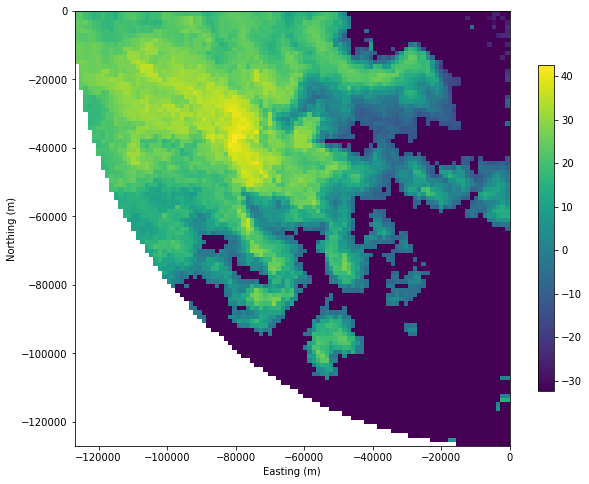

In [16]:
xy=np.concatenate([x.ravel()[:,None],y.ravel()[:,None]], axis=1)
gridded = wrl.comp.togrid(xy, grid_xy, 128000., np.array([x.mean(), y.mean()]), data.ravel(), wrl.ipol.Nearest)
gridded = np.ma.masked_invalid(gridded).reshape((len(xgrid), len(ygrid)))

fig = pl.figure(figsize=(10,8))
ax = pl.subplot(111, aspect="equal")
pm = pl.pcolormesh(xgrid, ygrid, gridded)
pl.colorbar(pm, shrink=0.75)
pl.xlabel("Easting (m)")
pl.ylabel("Northing (m)")
pl.xlim(min(xgrid), max(xgrid))
pl.ylim(min(ygrid), max(ygrid))

<div class="alert alert-info">

**Seealso** <br>

Get more info about the function [wradlib.comp.togrid()](https://docs.wradlib.org/en/latest/generated/wradlib.comp.togrid.html).

</div>

## Adjustment by rain gage observations

Adjustment normally refers to using rain gage observations on the ground to correct for errors in the radar-based rainfall estimating. [Goudenhoofdt et al., 2009](https://docs.wradlib.org/en/latest/zreferences.html#goudenhoofdt2009) provide an excellent overview of adjustment procedures. A typical approach is to quantify the error of the radar-based rainfall estimate *at* the rain gage locations, assuming the rain gage observation to be accurate. The error can be assumed to be additive, multiplicative, or a mixture of both. Most approaches assume the error to be heterogeneous in space. Hence, the error at the rain gage locations will be interpolated to the radar bin (or grid) locations and then used to adjust (correct) the raw radar rainfall estimates.

In the following example, we will use an illustrative one-dimensional example with synthetic data (just imagine radar rainfall estimates and rain gage observations along one radar beam). 

First, we create the synthetic "true" rainfall (``truth``):

In [17]:
import numpy as np
radar_coords = np.arange(0,101)
np.random.seed(1319622840)
truth = np.abs(1.5+np.sin(0.075*radar_coords)) + np.random.uniform(-0.1,0.1,len(radar_coords))

The radar rainfall estimate ``radar`` is then computed by imprinting a multiplicative ``error`` on ``truth`` and adding some noise:

In [18]:
error = 0.75 + 0.015*radar_coords
np.random.seed(1319622840)
radar = error * truth + np.random.uniform(-0.1,0.1,len(radar_coords))

Synthetic gage observations ``obs`` are then created by selecting arbitrary "true" values:

In [19]:
obs_coords = np.array([5,10,15,20,30,45,65,70,77,90])
obs = truth[obs_coords]

Now we adjust the ``radar`` rainfall estimate by using the gage observations. First, you create an "adjustment object" from the approach you want to use for adjustment. After that, you can call the object with the actual data that is to be adjusted. Here, we use a multiplicative error model with spatially heterogenous error (see [wradlib.adjust.AdjustMultiply()](https://docs.wradlib.org/en/latest/generated/wradlib.adjust.AdjustMultiply.html):

In [20]:
adjuster = wrl.adjust.AdjustMultiply(obs_coords, radar_coords, nnear_raws=3)
adjusted = adjuster(obs, radar)

Let's compare the ``truth``, the ``radar`` rainfall estimate and the ``adjusted`` product:

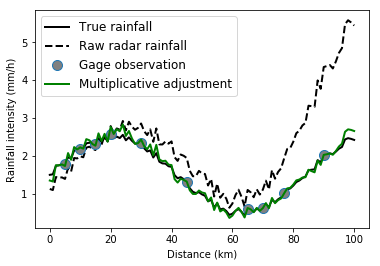

In [21]:
pl.plot(radar_coords, truth, 'k-', label="True rainfall", linewidth=2.)
pl.xlabel("Distance (km)")
pl.ylabel("Rainfall intensity (mm/h)")
pl.plot(radar_coords, radar, 'k-', label="Raw radar rainfall", linewidth=2., linestyle="dashed")
pl.plot(obs_coords, obs, 'o', label="Gage observation", markersize=10.0, markerfacecolor="grey")
pl.plot(radar_coords, adjusted, '-', color="green", label="Multiplicative adjustment", linewidth=2., )
pl.legend(prop={'size':12})

<div class="alert alert-info">

**Seealso** <br>

Get more info in the library reference section [Gage Adjustment](https://docs.wradlib.org/en/latest/adjust.html). There, you will also learn how to use the built-in *cross-validation* in order to evaluate the performance of the adjustment approach.

</div>

## Verification and quality control

Typically, radar-based precipitation estimation and the effectiveness of the underlying correction and adjustment methods are verified by comparing the results against rain gage observations on the ground. [wradlib.verify](https://docs.wradlib.org/en/latest/verify.html) module provides procedures not only to extract the radar values at specific gauge locations, but also a set of error metrics which are computed from gage observations and the corresponding radar-based precipitation estimates (including standard metrics such as RMSE, mean error, Nash-Sutcliffe Efficiency). In the following, we will illustrate the usage of error metrics by comparing the "true" rainfall against the raw and adjusted radar rainfall estimates from the above example:

In [22]:
raw_error  = wrl.verify.ErrorMetrics(truth, radar)
adj_error  = wrl.verify.ErrorMetrics(truth, adjusted)

Error metrics can be reported e.g. as follows:

In [23]:
print("Error metrics for unadjusted radar rainfall estimates:")
raw_error.pprint()
print("\nError metrics for adjusted radar rainfall estimates:")
adj_error.pprint()

Error metrics for unadjusted radar rainfall estimates:
{'corr': 0.69,
 'mas': 0.77,
 'meanerr': 0.69,
 'mse': 1.19,
 'nash': -1.54,
 'pbias': 43.4,
 'r2': 0.48,
 'ratio': 1.5,
 'rmse': 1.09,
 'spearman': 0.77,
 'sse': 120.29}

Error metrics for adjusted radar rainfall estimates:
{'corr': 1.0,
 'mas': 0.06,
 'meanerr': 0.03,
 'mse': 0.01,
 'nash': 0.98,
 'pbias': 1.9,
 'r2': 0.99,
 'ratio': 1.01,
 'rmse': 0.1,
 'spearman': 0.99,
 'sse': 0.79}


<div class="alert alert-info">

**Seealso** <br>

Get more info in the library reference section [Verification](https://docs.wradlib.org/en/latest/verify.html).

</div>

## Visualisation and mapping

In the above sections [Reading the data](#Reading-the-data), [Clutter removal](#Clutter-removal), and [Gridding](#Gridding) you already saw examples of the $\omega radlib's$ plotting capabilities.

<div class="alert alert-info">

**Seealso** <br>

Get more info in the library reference section [Visualisation](https://docs.wradlib.org/en/latest/vis.html).

</div>

## Data export to other applications

Once you created a dataset which meets your requirements, you might want to export it to other applications or archives. $\omega radlib$ does not favour or support a specific output format. Basically, you have all the freedom of choice offered by Python and its packages in order to export your data. Arrays can be stored as text or binary files by using numpy functions. You can use the package [NetCDF4](https://unidata.github.io/netcdf4-python/) to write NetCDF files, and the packages [h5py](https://www.h5py.org/) or [PyTables](https://www.pytables.org) to write hdf5 files.
At a later stage of development, $\omega radlib$ might support a standardized data export by using the OPERA's ODIM_H5 data model (see [Supported Radar Data Formats](../fileio/wradlib_radar_formats.ipynb)). Of course, you can also export data as images. See [Visualisation](https://docs.wradlib.org/en/latest/vis.html) for some options.

Export your data array as a text file:

In [24]:
np.savetxt("mydata.txt", data)

Or as a gzip-compressed text file:

In [25]:
np.savetxt("mydata.gz", data)

Or as a NetCDF file:

In [26]:
import netCDF4
rootgrp = netCDF4.Dataset('test.nc', 'w', format='NETCDF4')
sweep_xy = rootgrp.createGroup('sweep_xy')
dim_azimuth = sweep_xy.createDimension('azimuth', None)
dim_range = sweep_xy.createDimension('range', None)
azimuths_var = sweep_xy.createVariable('azimuths','i4',('azimuth',))
ranges_var = sweep_xy.createVariable('ranges','f4',('range',))
dBZ_var = sweep_xy.createVariable('dBZ','f4',('azimuth','range',))
azimuths_var[:] = np.arange(0,360)
ranges_var[:] = np.arange(0, 128000., 1000.)
dBZ_var[:] = data

You can easily add metadata to the NetCDF file on different group levels:

In [27]:
rootgrp.bandwith = "C-Band"
sweep_xy.datetime = "2012-11-02 10:15:00"
rootgrp.close()

<div class="alert alert-info">

**Note** <br>

An example for hdf5 export will follow.

</div>